In [1]:
import numpy as np

##################################################
##### Matplotlib boilerplate for consistency #####
##################################################
from ipywidgets import interact
from ipywidgets import FloatSlider
from matplotlib import pyplot as plt

%matplotlib inline

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

global_fig_width = 8
global_fig_height = global_fig_width / 1.61803399
font_size = 12

plt.rcParams['axes.axisbelow'] = True
plt.rcParams['axes.edgecolor'] = '0.8'
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.labelpad'] = 8
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['axes.titlepad'] = 16.0
plt.rcParams['axes.titlesize'] = font_size * 1.4
plt.rcParams['figure.figsize'] = (global_fig_width, global_fig_height)
plt.rcParams['font.sans-serif'] = ['Computer Modern Sans Serif', 'DejaVu Sans', 'sans-serif']
plt.rcParams['font.size'] = font_size
plt.rcParams['grid.color'] = '0.8'
plt.rcParams['grid.linestyle'] = 'dashed'
plt.rcParams['grid.linewidth'] = 2
plt.rcParams['lines.dash_capstyle'] = 'round'
plt.rcParams['lines.dashed_pattern'] = [1, 4]
plt.rcParams['xtick.labelsize'] = font_size
plt.rcParams['xtick.major.pad'] = 4
plt.rcParams['xtick.major.size'] = 0
plt.rcParams['ytick.labelsize'] = font_size
plt.rcParams['ytick.major.pad'] = 4
plt.rcParams['ytick.major.size'] = 0
##################################################

# Course Structure

- Lecture 1: Introduction to Bayesian Inference and Pints
- **Lecture 2: Maximum Likelihood Estimation**
   - **The Likelihood function**
   - **Maximum Likelihood Estimation**
   - **Maximum a Posteriori Esimation**
- Lecture 3: MCMC sampling
- Lecture 4: Hierarchical models

# Likelihood

- Recall the likelihood appears in Bayes' Theorem 

$$P(\theta | data) = \frac{\color{red}{{P(data|\theta)}} P(\theta)}{P(data)}$$

- Remember not a probability distribution because $\theta$ varies
- Most important choice, derived from the statistical model of the underlying process
- Encapsulates many subjective judgements about analysis.

# Equivalence relation

- A notation often seen in the literature is

$$\mathcal{L}(\theta | data) = P(data | \theta)$$

Therefore, a likelihood of $\theta$ for a particular data sample is equivalent to the probability of that data sample for that value of $\theta$. We call the above an *equivalence relation*

# Example:  frequency of lift malfunctioning


- Imagine we want to create a model for the frequency a lift (elevator) breaks down in a given year, $X$.
- Assume a range of unpredictable and uncorrelated factors (temperature, lift usage, etc.) affect the functioning of the lift.
- therefore, $X ∼ \text{Poisson}(\theta)$, where $\theta$ is the mean number of times the lift breaks in one year.
- we don’t a priori know the true value of $\theta$, our model defines collection of probability models; one for each value of $\theta$.
- We call this collection of models the Likelihood.

![](fig/miscellaneous-elevator_repairman-elevators-lifts-repairs-repairmen-mban2852_low.jpg)


In [2]:
import math
from scipy.stats import poisson
def lift_likelihood(theta, data):
    x = np.arange(0, 20)
    plt.plot(x, poisson.pmf(x, theta), 'bo', ms=8, label='poisson pmf')
    plt.vlines(x, 0, poisson.pmf(x, theta), colors='b', lw=5, alpha=0.5)
    print(data)
    if data is not None:
        plt.vlines([data], 0, poisson.pmf(data, theta), colors='r', lw=5, alpha=0.9)
    plt.ylim(0,0.25)
    plt.ylabel(r'$P(X | \theta=%s)$'%str(theta))
    plt.xlabel('X')
    plt.show()
def lift_likelihood_no_data(theta):
    lift_likelihood(theta,None)
def lift_likelihood_five_data(theta):
    lift_likelihood(theta,5)
    
def lift_likelihood_w_theta(k):
    theta = np.linspace(0, 20, 100)
    plt.plot(theta, np.exp(-theta)*theta**k/(math.factorial(k)))
    plt.ylabel(r'$P(k=%s | \theta)$'%str(k))
    plt.xlabel(r'mean number of breakdowns $\theta$')
    plt.show()

In [3]:
# Display our collection of models
widget = FloatSlider(value=5.0, min=0.0, max=15.0, step=1.0, continuous_update=False)
interact(lift_likelihood_no_data, theta=widget, continuous_update=False);

interactive(children=(FloatSlider(value=5.0, continuous_update=False, description='theta', max=15.0, step=1.0)…

To calculate the likelihood:
- fix the data (say number of breakdowns is measured at 5)
- find the corresponding probability for each of the models

In [4]:
interact(lift_likelihood_five_data, theta=widget, continuous_update=False);

interactive(children=(FloatSlider(value=5.0, continuous_update=False, description='theta', max=15.0, step=1.0)…

Using the equation for a Poisson distribution, and $k=5$ as the number of breakdowns, the likelihood function is:
    
$$\mathcal{L}(\theta | k) = P(k | \theta) = \exp(-\theta)\frac{\theta^k}{k!}$$

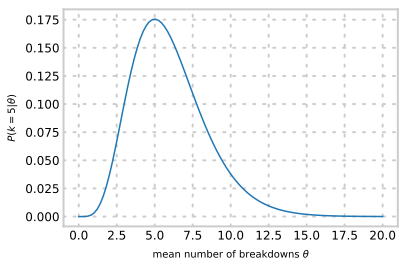

In [5]:
lift_likelihood_w_theta(5)

# Example: ODE-based model

- Models can often take the form of differential equations evolving in time
- Likelihood is often straightforward to derive and relativly cheap to calculate due to *independent* (in time) measurement noise 
- Lets consider the case of an ordinary differential equation (ODE) model, the reversible reaction model in the previous lecture:

$$\dot{y}(t) = k_1 (1 - y) - k_2 y,$$

where $k_1$ represents a forward reaction rate, $k_2$ is the backward reaction rate, and $y$ represents the concentration of a chemical solute.

- In an experiment, we take $N$ measurements of the system $z_i$, with $i = 0...N-1$, that are modelled with independent Gaussian measurement noise:

$$z_i \sim y(t_i) + N(0, \sigma)$$

- Assuming that $\sigma$ is unknown, we now have **three** model parameters: $\boldsymbol{\theta} = [k_1, k_2, \sigma]$, rather than one in the previous lift example

Lets look at a random realisations of this experiment, with $N=50$, $k_1=5$, $k_2=3$, and $\sigma=0.02$

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

def r(y, t, p):
    k1 = p[0] 
    k2 = p[1] 
    dydt = k1 * (1 - y) - k2 * y
    return dydt

def random(p):
    y0 = 0.1 
    times = np.linspace(0, 1, 50)
    values = odeint(r, y0, times, (p,))
    values += np.random.normal(0, 0.02, values.shape)
    plt.ylabel('Concentration')
    plt.scatter(times, values)
    plt.show()

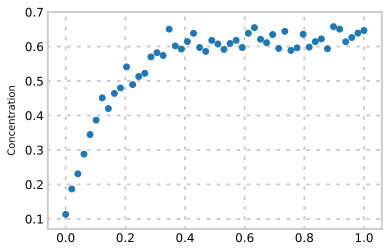

In [7]:
random([5,3])

- As before, this model describes an infinite family of probability distributions governed by the three parameters $\boldsymbol{\theta} = [k_1, k_2, \sigma]$
- However, now we have $N$ outputs due to the $N$ time samples that were measured, therefore a probabilty distribution around each time point $t_i$

In [8]:

from scipy.stats import norm
def family_of_models(k1, k2, sigma):
    y0 = 0.1 
    times = np.linspace(0, 1, 50)
    index = int(len(times)/2)
    values = odeint(r, y0, times, ([k1, k2],)).reshape(-1)
    global_fig_width = 8
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 8/1.618))
    ax1.set_ylabel('Concentration')    
    ax1.set_xlabel(r'$t$')
    ax1.plot(times, values)
    ax1.fill_between(times, values-sigma, values+sigma, alpha=0.5)
    ax1.axvline(times[index],color='r')
    
    concentrations = np.linspace(0, 1, 100)
    ax2.plot(concentrations, norm.pdf(concentrations, values[index], sigma), color='r')
    ax2.set_xlabel('concentration')
    ax2.set_ylabel(r'$P(y(t_i) | \theta)$')
    plt.show()

k1_widget = FloatSlider(value=5.0, min=0.0, max=15.0, step=1.0, continuous_update=False)
k2_widget = FloatSlider(value=3.0, min=0.0, max=15.0, step=1.0, continuous_update=False)
sigma_widget = FloatSlider(value=0.1, min=0.0, max=0.2, step=0.01, continuous_update=False)

In [9]:
# Display our collection of models
interact(family_of_models, k1=k1_widget, k2=k2_widget, sigma=sigma_widget, continuous_update=False);

interactive(children=(FloatSlider(value=5.0, continuous_update=False, description='k1', max=15.0, step=1.0), F…

# Likelihood of ODE model

- we assume that the errors at each time point are independent, therefore the conditional probability density of observing the whole experimental trace from time sample 1 to time sample N is simply the product of the probability density functions at each time point

$$\mathcal{L}(\theta \vert \mathbf{y}) = \prod_{i=1}^{N} P(z_i | \boldsymbol{\theta}).$$

- With our further assumption that the experimental noise is also normally distributed with a mean of zero and variance of $\sigma^2$ , the likelihood can be expressed as

\begin{equation}
\mathcal{L}(\boldsymbol{\theta} \vert \mathbf{z}) =  \prod_{i=1}^{N} \mathcal{N}(z_i \vert y(t, \boldsymbol{\theta}),\sigma^2) = \prod_{i=0}^{N} \frac{1}{\sqrt{2 \pi \sigma^2}} \exp \left(-\frac{\left(z_i -y(t_i, \boldsymbol{\theta})\right)^2}{2\sigma^2}\right),
\end{equation}

- Note that we denote the solution of the ODE as $y(t_i, \boldsymbol{\theta})$, to emphasis that the solution is a function of the parameters $\boldsymbol(\theta)$

- Normally work with the log-likelihood:

\begin{align}
l(\boldsymbol{\theta} \vert \mathbf{z}) &= \log(\mathcal{L}(\boldsymbol{\theta} \vert \mathbf{z})) \nonumber \\
&= -\frac{N}{2}\log(2\pi\sigma^2)-\frac{1}{2\sigma^2}\sum_{i=1}^N (z_i - y(t_i, \boldsymbol{\theta}))^2 \nonumber \\
&= -\frac{N}{2}\log(2\pi) - N\log(\sigma) - \frac{1}{2\sigma^2}\sum_{i=1}^N (z_i - y (t_i, \boldsymbol{\theta}))^2
\end{align}

- Notice the similarities with classical sum of squares error function (for fixed $\sigma$ anyway)!

In [10]:
def calculate_log_likelihood(k1, k2, sigma, data, times, y0):
    N = len(times)
    values = odeint(r, y0, times, ([k1, k2],)).reshape(-1)
    return -N/2.0*np.log(2*np.pi) - N*np.log(sigma) - (1.0/(2.0*sigma**2)) * np.sum((data - values)**2)

In [11]:
def calculate_log_likelihood_all(K1, K2, sigma):
    N = 50
    y0 = 0.1 
    times = np.linspace(0, 1, N)
    result = np.empty_like(K1)
    data = odeint(r, y0, times, ([5, 3],)).reshape(-1) + np.random.normal(0, sigma, times.shape)
    for i,(k1,k2) in enumerate(zip(K1,K2)):
        result[i] = calculate_log_likelihood(k1, k2, sigma, data, times, y0)
    return result

def show_ode_log_likelihood(sigma):
    k1 = np.linspace(0, 15, 50)
    k2 = np.linspace(0, 15, 50)
    K1, K2 = np.meshgrid(k1, k2)
    log_likelihood = calculate_log_likelihood_all(K1.flat, K2.flat, sigma).reshape(K1.shape)
    
    plt.contourf(K1, K2, log_likelihood, 20, cmap='RdGy', levels=30);
    plt.xlabel(r'$k_1$')
    plt.ylabel(r'$k_2$')
    plt.title('log-likelihood for ODE model')
    plt.colorbar()
    plt.show()

In [12]:
interact(show_ode_log_likelihood, sigma=FloatSlider(value=0.01, min=0.001, max=0.1, step=0.001, continuous_update=False));

interactive(children=(FloatSlider(value=0.01, continuous_update=False, description='sigma', max=0.1, min=0.001…

# Maximum Likelihood Estimation

- In the previous lecture we worked out the posterior *distribution* a given parameter, given the available data
- Often only interested in the most *likely* parameter value
- Can use maximum likelihood estimation, simply find the value of $\theta$ that maximises the likelihood
- a **frequentist** approach, uses a likelihood function (not a valid probability distribution)

$$\theta_{mle} = \text{arg max}_{\theta \in \Omega} P(data|\theta)$$

# Coin example

![](fig/coin.jpeg)

- Back to the coin example. We perform an experiment of $n$ flips, and it lands heads up $h$ times

- Likelihood is:

$$\mathcal{L}(\theta \vert h\times H) = \theta^h (1-\theta)^{n-h}$$

# Finding the parameters that maximise the Likelihood

- For tractable likelihood functions, we can simply find the derivative of the likelihood and set to zero:
    
$$\frac{\partial \mathcal{L}(\theta \vert h\times H)}{\partial \theta} = \theta^{h - 1} (h - n \theta) (1-\theta)^{n -h - 1}$$

- Set $\frac{\partial \mathcal{L}(\theta \vert h\times H)}{\partial \theta} = 0$ to find the MLE estimator for $\theta$

$$\theta_{mle} = \frac{h}{n}$$


In [13]:
def show_mle_coin(h):
    n = 10
    theta = np.linspace(0,1,100)
    L = theta**h * (1-theta)**(n-h)
    plt.plot(theta,L, label='loss function')
    plt.xlabel(r'Probability of landing heads $\theta$')
    plt.ylabel(r'MLE loss function $L(\theta)$')
    max_L = h / n
    plt.vlines(max_L, 0, np.max(L), color='r', linestyle='dashed', linewidth=2)
    plt.scatter([max_L],[np.max(L)], color='r', label='MLE estimate', s=100)
    plt.legend()
    plt.show()
    
h_widget = FloatSlider(value=8.0, min=0.0, max=10.0, step=1.0, continuous_update=False)

In [14]:
interact(show_mle_coin, h=h_widget);

interactive(children=(FloatSlider(value=8.0, continuous_update=False, description='h', max=10.0, step=1.0), Ou…

## Fisher information and the MLE estimator

- A measure of information (for $\theta$) contained in the data $X$ is given by the Fisher information $I(\theta)$

$$I(\theta) = -E\left[\frac{\partial^2 l(\theta | X)}{\partial \theta^2}\right]$$

- For large number of samples $N$, the MLE estimator converges to the true $\theta_0$ by

$$\theta_{mle} \sim \mathcal{N} \left(\theta_0, \frac{1}{NI(\theta)} \right)$$

- Corresponding approximate 95% confidence intervals for $\theta_0$ are

$$\theta_{mle} - 1.96 \sqrt{\frac{1}{nI(\theta)}} \le \theta_0 \le \theta_{mle} + 1.96 \sqrt{\frac{1}{nI(\theta)}}$$

# Non-linear optimisation

- Often the analytical approach is not feasible, can then turn to one of many non-linear optimisation algorithms
- Derivative-free Direct methods (aka Search methods)
  - Brute-force exploration (look at the landscape and pick the lowest point)
  - Random search (e.g. Simulated annealing) 
  - Coordinate search (aka Coordinate descent, aka Compass search)
  - Search & poll / Pattern search
  - Simplex methods (e.g. Nelder-Mead)
  - Tabu search
  - Dividing rectangles algorithm (DIRECT)
  - Powell's conjugate direction method
- Multi-start methods
  - Multi-level single-linkage (MLSL)
  - Basin-hopping
- Derivative-free evolutionary methods and metaheuristics
  - Genetic algorithms (GA)
  - Differential evolution
  - Evolution strategies
  - Controlled random search (CRS)
  - Swarm algorithms
  - Metaheuristics
- Bayesian optimistation
- Gradient-estimating methods
  - Finite difference methods
  - Simplex gradient methods / Implicit filtering
  - Natural evolution strategies (NES)
- Surrogate-model methods
  - Trust-region methods
  - Data-based Online Nonlinear Extremumseeker (DONE)
- Methods requiring the 1st-order gradient
  - Root finding methods (e.g. Newton's method, BFGS)
  - Gradient descent (aka Steepest descent)
  - Stochastic gradient descent
  - Continuation

# Some useful non-linear optimisation packages:

- [NLopt](https://nlopt.readthedocs.io)
- [Pagmo/Pygmo](http://esa.github.io/pygmo/)
- [Scipy](https://docs.scipy.org/doc/scipy/reference/optimize.html)
- [Pints](https://pints.readthedocs.io/en/latest/)

# Example using PINTS

- We will use a popular model of population growth, the logistic equation:

    $$ \frac{dy(t)}{dt} = r y(t) \frac{k - y(t)}{k}$$
    
- Two parameters, the carrying capacity $k$, and the rate of growth $r$
- We will assume an unknown measurement noise $\sigma$, which gives the parameter set $\boldsymbol{\theta} = [r, k, \sigma]$
- The `pints.GaussianLogLikelihood` in PINTS implements the independent Gaussian noise log-likelihood derived earlier

\begin{align}
l(\boldsymbol{\theta} \vert \mathbf{z}) &= \log(L(\boldsymbol{\theta} \vert \mathbf{z})) \nonumber \\
&= -\frac{N}{2}\log(2\pi) - N\log(\sigma) - \frac{1}{2\sigma^2}\sum_{i=1}^N (z_i - y (t_i, \boldsymbol{\theta}))^2
\end{align}

In [15]:
import pints
import pints.toy
import matplotlib.pyplot as plt
import numpy as np

p0 = 1  # initial population; initial value
model = pints.toy.LogisticModel(p0)

# Define the 'true' parameters
true_parameters = [0.1, 50, 5]

# Run a simulation to get test data
times = np.linspace(0, 100, 100)
values = model.simulate(true_parameters[:-1], times)

# Add some noise
values += np.random.normal(0, true_parameters[-1], values.shape)


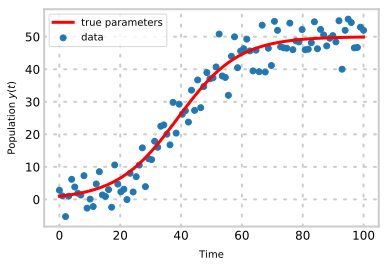

In [16]:
# Show the test data
plt.figure()
plt.xlabel('Time')
plt.ylabel(r'Population $y(t)$')
plt.scatter(times, values, label='data')
plt.plot(times, model.simulate(true_parameters[:-1], times), color='r', lw=3, label='true parameters')
plt.legend()
plt.show()

In [17]:
# Create an object with links to the model and time series
problem = pints.SingleOutputProblem(model, times, values)

# Create the log-likelihood function
log_likelihood = pints.GaussianLogLikelihood(problem)

# Select some boundaries
boundaries = pints.RectangularBoundaries([0, 0, 0], [100, 100, 100])

# Select a starting point
x0 = [50, 50, 50]

# Perform an optimization using XNES. 
found_parameters, found_value = pints.optimise(log_likelihood, x0, boundaries=boundaries, method=pints.XNES)
print('log_likelihood at true solution:')
print(log_likelihood(true_parameters))

Maximising LogPDF
using Exponential Natural Evolution Strategy (xNES)
Running in sequential mode.
Population size: 7
Iter. Eval. Best      Time m:s
0     7     -481.7851   0:00.0
1     14    -449.7718   0:00.0
2     21    -443.2462   0:00.0
3     28    -439.0006   0:00.0
20    147   -438.9613   0:00.0
40    287   -438.9469   0:00.1
60    427   -438.9469   0:00.1
80    567   -438.9469   0:00.1
100   707   -438.9469   0:00.1
120   847   -438.9469   0:00.1
140   987   -438.9469   0:00.1
160   1127  -438.9469   0:00.1
180   1267  -438.9469   0:00.2
200   1407  -438.9469   0:00.2
220   1547  -438.9469   0:00.2
240   1687  -438.9469   0:00.2
260   1827  -438.9469   0:00.2
280   1967  -438.9469   0:00.2
284   1988  -438.9469   0:00.2
Halting: No significant change for 200 iterations.
log_likelihood at true solution:
-288.64023040857603


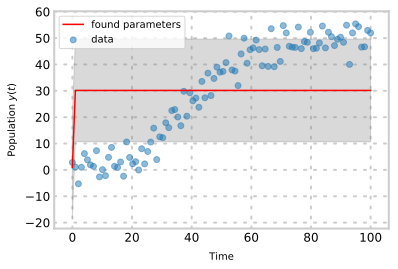

In [18]:
# Show the results
plt.figure()
plt.xlabel('Time')
plt.ylabel(r'Population $y(t)$')
found_mean = model.simulate(found_parameters[:-1], times)
plt.fill_between(times, found_mean - found_parameters[-1], found_mean + found_parameters[-1],
                 color='gray', alpha=0.3)
plt.plot(times, found_mean, color='r', label='found parameters')
plt.scatter(times, values, alpha=0.5, label='data')
plt.legend()
plt.show()

# Maximum a posteriori (MAP) estimation

- Rather than a likelihood, can also maximise the unnormalised posterior:

$$P(\theta | data) \sim P(data|\theta) P(\theta)$$

$$\theta_{map} = \text{arg max}_{\theta \in \Omega}  P(data|\theta) P(\theta)$$

- MLE is a particular case of MAP, using a Uniform prior (just multiplies the likelihood by a constant)
- This method is a useful method of incorporporating domain knowledge on the parameters
- Related to regularisation in non-linear and linear optimisation


# Coin example with a Gaussian prior

![](fig/coin.jpeg)

- Reasonable assumption is that the coin is likely to be fair, lets use a Gaussian prior $N(0.5, \sigma)$

- Maximum a posteriori loss function $L(\theta)$ is therefore:

\begin{align*}
L(\theta) &= P(data|\theta) P(\theta) \\ 
&= \theta^h (1-\theta)^{n-h} \frac{1}{\sqrt{2 \pi \sigma^2}} e^{-\frac{(\theta - 0.5)^2}{2 \sigma^2}}
\end{align*}

In [19]:
def show_map_coin(h, sigma):
    n = 10
    theta = np.linspace(0,1,100)
    L = theta**h * (1-theta)**(n-h) * np.exp(-(theta - 0.5)**2/(2*sigma**2)) / np.sqrt(2*np.pi*sigma**2)
    plt.plot(theta,L, label='loss function')
    plt.xlabel(r'Probability of landing heads $\theta$')
    plt.ylabel(r'MAP loss function $L(\theta)$')
    max_i = np.argmax(L)
    plt.scatter([theta[max_i]],[L[max_i]], color='r', label='MAP estimate', s=100)
    plt.legend()
    plt.show()
    
h_widget = FloatSlider(value=8.0, min=0.0, max=10.0, step=1.0, continuous_update=False)
sigma_widget = FloatSlider(value=0.3, min=0.0, max=0.3, step=0.01, continuous_update=False)

In [20]:
interact(show_map_coin, h=h_widget, sigma=sigma_widget, continuous_update=False);

interactive(children=(FloatSlider(value=8.0, continuous_update=False, description='h', max=10.0, step=1.0), Fl…

# Logistic growth example

Recall the logistic equation:
    
$$f(t) = \frac{k}{1+(k/p_0 - 1) \exp(-r t)}$$

- Anyone familiar with this equation could estimate a value of the carrying capacity $k$ from a plot
- Would be reasonable to therefore use a Gaussian Prior for $k$
  

In [21]:
def show_logistic_estimate():
    plt.xlabel('Time')
    plt.ylabel(r'Population $y(t)$')
    plt.scatter(times, values, label='data')
    plt.plot([0, 100], [50, 50], c='k', ls='--', lw=3, label='estimate for $k$')
    plt.legend()
    plt.show()

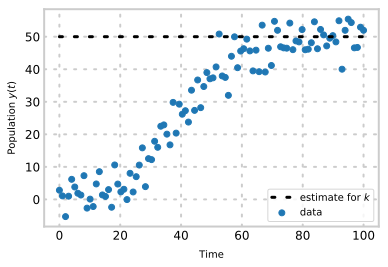

In [22]:
show_logistic_estimate()

## Finding MAP estimator in PINTS

In [23]:
# Create the log-likelihood function (using the problem defined earlier)
log_likelihood = pints.GaussianLogLikelihood(problem)

# Create a uniform prior over r
log_prior_r = pints.UniformLogPrior([0],[100])

# Create a gaussian prior over k
log_prior_k = pints.GaussianLogPrior(50,10)

# Create a uniform prior over sigma
log_prior_sigma = pints.UniformLogPrior([0],[100])

# Create a composed prior
log_prior = pints.ComposedLogPrior(log_prior_r, log_prior_k, log_prior_sigma)

In [24]:
# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

# Select some boundaries
boundaries = pints.RectangularBoundaries([0, 0, 0], [100, 100, 100])

# Select a starting point
x0 = [50, 50, 50]

# Perform an optimization using Particle Swarm Optimisation (PSO). 
found_parameters, found_value = pints.optimise(log_likelihood, x0, boundaries=boundaries, method=pints.PSO)
print('posterior log-likelihood at true solution:')
print(log_posterior(true_parameters))

Maximising LogPDF
using Particle Swarm Optimisation (PSO)
Running in sequential mode.
Population size: 7
Iter. Eval. Best      Time m:s
0     13    -489.3967   0:00.0
1     26    -489.3967   0:00.0
2     39    -475.6101   0:00.0
3     52    -463.3096   0:00.0
20    273   -439.1372   0:00.0
40    533   -438.9546   0:00.0
60    793   -438.9546   0:00.1
80    1053  -400.392    0:00.1
100   1313  -399.0795   0:00.1
120   1573  -397.7643   0:00.1
140   1833  -396.5449   0:00.1
160   2093  -383.5393   0:00.1
180   2353  -330.0047   0:00.1
200   2613  -311.9692   0:00.1
220   2873  -286.0045   0:00.2
240   3133  -286.0045   0:00.2
260   3393  -286.0045   0:00.2
280   3653  -286.0045   0:00.2
300   3913  -286.0045   0:00.2
320   4173  -286.0045   0:00.2
340   4433  -286.0045   0:00.2
360   4693  -286.0045   0:00.3
380   4953  -286.0045   0:00.3
400   5213  -286.0045   0:00.3
408   5304  -286.0045   0:00.3
Halting: No significant change for 200 iterations.
posterior log-likelihood at true solut

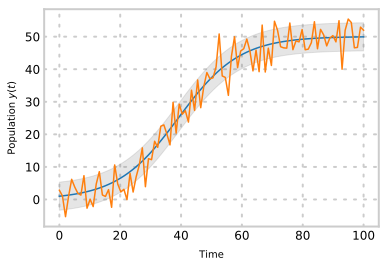

In [25]:
# Show the results
plt.figure()
plt.xlabel('Time')
plt.ylabel(r'Population $y(t)$')
found_mean = model.simulate(found_parameters[:-1], times)
plt.fill_between(times, found_mean - found_parameters[-1], found_mean + found_parameters[-1],
                 color='gray', alpha=0.2)
plt.plot(times, found_mean)
plt.plot(times, values)
plt.show()

# Electrochemistry example - POMS

- three unresolved two-electron surface-confined polyoxometalate reduction processes by AC voltammetry

![](fig/pom.svg)
**(left)** Molecular structure of $[\text{PMo}_{12}\text{O}_{40}]^{3-}$    **(right)** Experimental AC voltammetry trace

- The sequence of six electron transfer steps are modelled by the following quasi-reversible reactions

\begin{align}
    A + e^- \underset{k^1_{ox}(t)}{\overset{k^1_{red}(t)}{\rightleftarrows}} B,
    \\
    B + e^- \underset{k^2_{ox}(t)}{\overset{k^2_{red}(t)}{\rightleftarrows}} C,
    \\
    C + e^- \underset{k^3_{ox}(t)}{\overset{k^3_{red}(t)}{\rightleftarrows}} D,
    \\
    D + e^- \underset{k^4_{ox}(t)}{\overset{k^4_{red}(t)}{\rightleftarrows}} E,
    \\
    E + e^- \underset{k^5_{ox}(t)}{\overset{k^5_{red}(t)}{\rightleftarrows}} F,
    \\
    F + e^-  \underset{k^6_{ox}(t)}{\overset{k^6_{red}(t)}{\rightleftarrows}} G,
\end{align}

where the forward $k_{red}$ and backwards $k_{ox}$ reaction rates are
given by
the Butler-Volmer
relationships

\begin{align}\label{eq:rate1}
    k^i_{red}(t) &= k^0_i \exp\left(-\frac{\alpha_i F}{RT} [E_r(t) - E^0_i]
    \right), \\
    k^i_{ox}(t) &= k^0_i \exp\left((1-\alpha_i)\frac{F}{RT} [E_r(t) - E^0_i]
\right).  \label{eq:rate2}
\end{align}

- This can be modelled by an ordinary differential equation containing 17 parameters to be estimated

$$
\mathbf{p} =
(E^0_1,E^0_2,E^0_3,E^0_4,E^0_5,E^0_6,k^0_1,k^0_2,k^0_3,k^0_4,k^0_5,k^0_6,
         \alpha_1,
         \alpha_2,
         R_u,
         C_{dl},
         \Gamma).
$$

- The effect of the $E^0_i$ parameters on the simulated current is highly non-linear.
- In such a high dimensional space all non-linear optimisers we tried failed to find the global minimum
- But approximate values of $E^0_i$ can be easily read off the experimental current trace.... **solution:** put a Gaussian prior on all $E^0_i$ parameters

**standard deviation** of the Gaussian prior (i.e. confidence of the estimation of $E^0_i$), required to be $<= 0.1$ V for **reliable parameter estimation**

![](fig/quasireversible.svg)

## Summary

- The likelihood function is derived from your model of the underlying process, and the experimental data
- It is often the most important choice, encapsulates many **subjective judgements**
- **Maximum likelihood estimation** (MLE) finds the *most likely* parameters that lead to the data
- **Maximum a posteriori estimation** (MAP) finds the most likely parameters that lead to the data, *given additional information* encoded in the prior
- **Non-linear Optimisation** methods are useful in both MLE and MAP estimation for non-trivial models.
